## Age prediction project
- In this project, I trained my a Age classifier with [EfficientNet](https://arxiv.org/abs/1905.11946) which was claimed to achiever better accuracy than than previous ConvNets. I applied transfer learning with __imagenet__ pre-trained weight and add custom layer. During training, I noticed a significant over-fitting trend, thus I added more _Dropout layer_ and apply _several data augmentation techniques_.

- I have created my own dataset consist of 51048 images divided among 9 age groups. However during training process, I realize my dataset is not a good training source since it didn't distributed evenly among age groups. In particularly, my classifier is bias toward the age group of 33-45 and 60 above.

- I also realized a noticeable pattern which can be related to humans' common sens in age classifying. My classifier considers features such as lighter skin, no beard, black hair, etc as indications for younger age while features such as wrinkles, white hair and beards, etc usually return older age-group results. 

- After long hours of training and tuning, I can only manage to achieve maximum 50% accuracy on my validation set, which is not a good result. I also tried with other popular networks as MobileNets, VGG16, ResNet50, Xcepticon but the accuracy were much worse than EfficientNet.

- My dataset can be downloaded from [here](https://drive.google.com/file/d/1q5LROuIN596pdMY3lMRULnM6PENPurou/view?usp=sharing).


In [ ]:
# untip downloaled dataset
!unzip ./Age_prediction_data.zip

# install efficientnet 
!pip install efficientnet

In [2]:
from keras import metrics
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from efficientnet.keras import EfficientNetB1
from keras.models import model_from_json, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import os
import pickle

### Visualizing Dataset

In [40]:
data = glob.glob("Data/*/*.jpg")
print("[INFO] Find {:d} image(s)...".format(len(data)))

[INFO] Find 51048 image(s)...


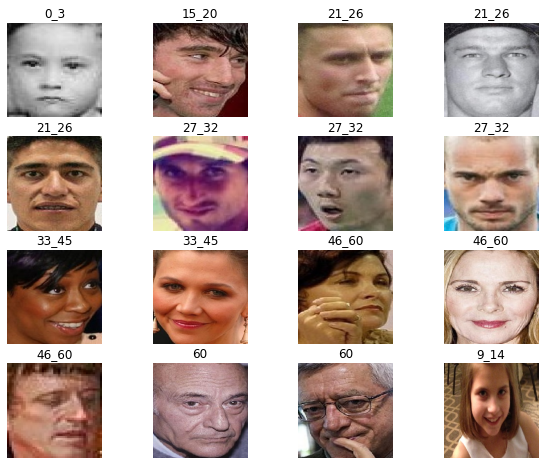

In [41]:
fig = plt.figure(figsize=(10,8))
cols = 4
rows = 4
grid = gridspec.GridSpec(ncols=cols,nrows=rows, figure=fig)
rand_list = np.linspace(0,len(data)-1,cols*rows).astype(np.int)

for i in range(cols*rows):
    fig.add_subplot(grid[i])
    plt.axis(False)
    image = load_img(data[rand_list[i]], target_size=(224,224))
    plt.title(os.path.dirname(data[rand_list[i]]).split("\\")[1])
    plt.imshow(image)

### Data augumenting and split

In [42]:
datagen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1, 
                              rescale=1/255,                    
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode="nearest", 
                              validation_split=0.05)

In [43]:
BATCH_SIZE=64
image_shape=(88,88,3)
train_image_gen = datagen.flow_from_directory("Data",
                                              target_size=image_shape[:2],
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              subset="training", 
                                              shuffle=True)

valid_image_gen = datagen.flow_from_directory("Data",
                                              target_size=image_shape[:2],
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              subset="validation", 
                                              shuffle=True)

with open("./models/labels.pkl","wb") as files:
  pickle.dump(train_image_gen.class_indices, files)

Found 48500 images belonging to 9 classes.
Found 2548 images belonging to 9 classes.


### Create model with base architecture of EfficientNet

In [4]:
def creat_model(lr=1e-3,decay=1e-3/25,classes=14):
    # load model without classifier layers
    baseModel = EfficientNetB1(weights="imagenet", include_top=False,
                      input_tensor=Input(shape=image_shape))    

    for layer in baseModel.layers:
      layer.trainable = True               
                     
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dropout(0.7)(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.25)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dense(classes, activation="softmax")(headModel)
    
    model = Model(input=baseModel.input, outputs = headModel)
    optimizer = Adam(lr=lr,decay=decay)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
    return model                         

In [6]:
# initialize hyperparameter
lr=1e-3
epochs=25
decay=1e-3/epochs
classes = len(train_image_gen.class_indices)
model = creat_model(lr, decay, classes)

# save model architecture
model_json = model.to_json()
with open("./model/age_prediction_efficienet.json", "w") as json_file:
    json_file.write(model_json)

W0626 19:51:22.604470 14584 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0626 19:51:22.617470 14584 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 88, 88, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 44, 44, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 44, 44, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 44, 44, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

### Training model

In [ ]:
FILE_PATH = "./model/age_prediction.h5"


my_checkpointer = [
                   EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                   ModelCheckpoint(filepath=FILE_PATH, monitor="val_accuracy",  verbose=1, save_best_only=True, mode="max")
                   ]


history = model.fit_generator(train_image_gen, 
                    epochs=25, 
                    steps_per_epoch=len(train_image_gen), 
                    validation_data=valid_image_gen, 
                    validation_steps=len(valid_image_gen), 
                    verbose=1,
                    callbacks=my_checkpointer)




Epoch 1/25
  1/758 [..............................] - ETA: 43:00:35 - loss: 2.4864 - accuracy: 0.1875

In [ ]:
with open("./models/labels.pkl","rb") as files:
  labels = pickle.load(files)

# retrun key from predicted value
def get_key(val, labels):
  for key, value in labels.items():
    if value==val: 
        if val==7:
            return "60_up"
        else:
            return key
        break

# process image and retrun label result
def predict_from_image(image_path, model, labels):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(88,88))
  img_resize = img/255
  img_reshape = img_resize[np.newaxis,:] 

  val = np.argmax(model.predict(img_reshape))
  return img, get_key(val,labels)

### Visualize predicting result

In [ ]:
#model.save_weights("./model/age_prediction_efficientnet.h5")

test_images = glob.glob("test_images/*.jpg")

cols = 3
rows = 3
fig = plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig)

for i in range(cols*rows):
  img, val = predict_from_image(test_images[i],model, labels)
  fig.add_subplot(grid[i])
  plt.axis(False)
  plt.title(val)
  plt.imshow(img)

#plt.savefig("age_predict_result.jpg", dpi=300)

### Discussion
- As you can see from visualized result, face features affect significantly to the prediction. The two pictures of Zay Efron were taken at the same year in 2019, one without and another with beard, were classified in two different age-groups of 21-26 and 33-45 respectively! 
- I combined two models of face detector and age classifier, and applied them on a footage which you can refered as below:
<br><p align="center"><img src="./test_video_result.gif" width=720></p><br>

- The code which I used to generate this footage is [`age_classifier.py`](./age_classifier.py)

# The End!